# Apply Classifier to Other Data

In this script we apply the classifier to obtain continuous scores that can be used in downstream applications.

We apply the multiple myeloma multiclass classifier trained in `1.train-classifier.py` to a cell line RNAseq data set. This data was also provided by Arun Wiita and Tony Lin (UCSF).

**Note: The classifier can be applied to other datasets by following the steps outlined in this notebook. The input data is expected to be in FPKM. Also note that the current approach is not likely to work well for smaller datasets since the FPKM genes are normalized across the dataset.**

In [1]:
import os
import random
import numpy as np
import pandas as pd

from statsmodels.robust.scale import mad
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt

from utils import shuffle_columns, get_confusion_matrix, apply_classifier

In [2]:
%matplotlib inline

In [3]:
random.seed(1234)

In [4]:
file = os.path.join('results', 'classifier', 'classifier_coefficients.tsv')
coef_df = pd.read_table(file, index_col=0)

coef_df.head()

,wildtype,KRAS,NRAS
GENE_ID,,,
ENSG00000244405,-1.250743,1.009203,0.387605
ENSG00000153064,-0.530025,0.880618,0.000000
ENSG00000131187,-0.798638,0.610847,0.293826
ENSG00000184445,-0.188369,0.497889,0.000000
ENSG00000143878,-0.090743,0.477435,0.000000


In [5]:
file = os.path.join('results', 'classifier', 'classifier_intercept.tsv')
intercept_df = pd.read_table(file, index_col=0)

intercept_df

,wildtype,KRAS,NRAS
intercept,0.019241,-0.135418,-0.013919


## Load and Process Cell Line X Matrix

In [6]:
file = os.path.join('data', 'raw', 'MMCL_RNAseq.csv')
mmcl_df = pd.read_csv(file, index_col=0).drop('GENE_NAME', axis='columns')

# Reorder genes based on MAD and retain higher variable genes
mmcl_df = (
    mmcl_df
    .assign(mad_genes = mad(mmcl_df, axis=1))
    .sort_values(by='mad_genes', ascending=False)
    .drop('mad_genes', axis='columns')
)

mmcl_df = mmcl_df[~mmcl_df.index.duplicated(keep='first')]

# Note that some genes were not measured in the MMCL data
mmcl_df = mmcl_df.reindex(coef_df.index).dropna().transpose()

print(mmcl_df.shape)
mmcl_df.head(2)

(65, 7789)


GENE_ID,ENSG00000244405,ENSG00000153064,ENSG00000131187,ENSG00000184445,ENSG00000143878,ENSG00000135046,ENSG00000090924,ENSG00000023318,ENSG00000101187,ENSG00000051523,...,ENSG00000052723,ENSG00000009307,ENSG00000152689,ENSG00000257698,ENSG00000134262,ENSG00000176533,ENSG00000140451,ENSG00000189227,ENSG00000198680,ENSG00000213281
ALMC1_DJ_p27,0.436696,2.96642,4.12506,47.9884,50.8966,0.395988,5.99873,11.2225,5.90203,960.395,...,34.5591,125.050,0.462205,19.3397,8.51330,7.88523,19.4352,15.5157,0.030108,27.4421
ALMC2_DJ_p11,0.391006,7.79499,12.65290,32.3999,102.7200,2.229870,4.36350,23.2649,2.77408,543.323,...,23.0183,143.905,1.615190,27.2094,9.32706,14.07420,12.4351,22.1436,0.077545,21.3625


In [7]:
# How many classifier genes are filtered?
nonzero_genes = set(coef_df.loc[(coef_df.sum(axis='columns').abs() > 0), :].index)

numcommon = len(set(mmcl_df.columns).intersection(nonzero_genes))
print("of the {} non zero genes, {} are present in MMCL ({} %)".format(len(nonzero_genes),
                                                                       numcommon,
                                                                       (numcommon / len(nonzero_genes)) * 100))

of the 834 non zero genes, 809 are present in MMCL (97.00239808153476 %)


In [8]:
# How many genes are missing
missing_genes = nonzero_genes.difference(set(mmcl_df.columns))
print("So, {} genes are missing.".format(len(missing_genes)))
missing_coef = coef_df.loc[missing_genes, :]
missing_coef = missing_coef.assign(abs_sum = missing_coef.abs().sum(axis='columns'))
missing_coef = missing_coef.sort_values(by='abs_sum', ascending=False)
print("Many of which are somewhat influential - must be careful in downstream interpretation")
missing_coef.head(5)

So, 25 genes are missing.
Many of which are somewhat influential - must be careful in downstream interpretation


,wildtype,KRAS,NRAS,abs_sum
GENE_ID,,,,
ENSG00000272379,0.187147,0.000000,-0.516751,0.703898
ENSG00000263136,0.378971,-0.091032,-0.136516,0.606519
ENSG00000268027,-0.130109,0.000000,0.281823,0.411932
ENSG00000272086,0.198382,-0.156167,0.000000,0.354549
ENSG00000268355,0.000000,0.318196,0.000000,0.318196


## Process Cell Line Y Matrix

In [9]:
file = os.path.join('data', 'raw', 'MMCL_RNAseq_labels.csv')
y_df = (
    pd.read_csv(file, index_col=0)
    .reindex(mmcl_df.index)
    .astype(int)
)
y_df.head(3)

,KRAS_mut,NRAS_mut,dual_RAS_mut
ALMC1_DJ_p27,0,0,0
ALMC2_DJ_p11,0,0,0
AMO1_DSMZ_p8,0,0,0


In [10]:
# Number of Ras mutations in the cell line dataset
y_df.sum()

KRAS_mut        17
NRAS_mut        13
dual_RAS_mut     0
dtype: int64

In [11]:
# Proportion of Ras mutations in the cell line dataset
y_df.sum() / y_df.shape[0]

KRAS_mut        0.261538
NRAS_mut        0.200000
dual_RAS_mut    0.000000
dtype: float64

In [12]:
# Recode the Y matrix
# sklearn expects a single column with classes separate 0, 1, 2
# Set NRAS mutations equal to 2
y_df.loc[y_df['NRAS_mut'] == 1, 'KRAS_mut'] = 2

y_df = y_df.drop(['NRAS_mut', 'dual_RAS_mut'], axis='columns')
y_df.columns = ['ras_status']
y_df.head()

,ras_status
ALMC1_DJ_p27,0
ALMC2_DJ_p11,0
AMO1_DSMZ_p8,0
ANBL6_DJ2_p13,0
COLO677_DSMZ_p8,1


In [13]:
# Recode y matrix for metric eval
y_onehot_df = OneHotEncoder(sparse=False).fit_transform(y_df)

## Apply Classifier to Cell Line Data

In [14]:
# Zero one normalize the cell line data
scaled_fit = MinMaxScaler().fit(mmcl_df)
mmcl_processed_df = pd.DataFrame(scaled_fit.transform(mmcl_df),
                                 index=mmcl_df.index,
                                 columns=mmcl_df.columns)
mmcl_processed_df.head()

GENE_ID,ENSG00000244405,ENSG00000153064,ENSG00000131187,ENSG00000184445,ENSG00000143878,ENSG00000135046,ENSG00000090924,ENSG00000023318,ENSG00000101187,ENSG00000051523,...,ENSG00000052723,ENSG00000009307,ENSG00000152689,ENSG00000257698,ENSG00000134262,ENSG00000176533,ENSG00000140451,ENSG00000189227,ENSG00000198680,ENSG00000213281
ALMC1_DJ_p27,0.003566,0.032300,0.056832,0.382812,0.103441,0.000423,0.189920,0.000000,0.071756,0.505963,...,0.417039,0.171719,0.000000,0.123383,0.135714,0.082713,0.722107,0.495906,0.001505,0.058966
ALMC2_DJ_p11,0.003080,0.085163,0.177475,0.245581,0.208831,0.002382,0.128631,0.232408,0.033564,0.269532,...,0.223250,0.220288,0.005243,0.208821,0.163018,0.147742,0.456304,0.797925,0.003875,0.021132
AMO1_DSMZ_p8,0.293989,0.016690,0.105057,0.108983,0.000054,0.002619,0.160601,0.213641,0.657199,0.117597,...,0.000000,0.000000,0.372236,0.330121,0.000000,0.209957,0.137332,0.079408,0.055431,0.027846
ANBL6_DJ2_p13,0.055594,0.095256,0.071360,0.206420,0.053757,0.000920,0.048104,0.242384,0.288870,1.000000,...,0.252575,0.141363,0.090797,0.010075,0.407025,0.744381,0.334841,0.325164,0.017991,0.095003
COLO677_DSMZ_p8,0.213208,0.000480,0.137187,0.389081,0.166456,0.052735,0.000000,0.279938,0.111612,0.195207,...,0.224823,0.364787,0.000239,0.265878,0.406052,0.130869,0.592476,0.389938,0.002000,0.155636


In [15]:
# Confirm that the samples are the same between training and testing
assert (y_df.index == mmcl_processed_df.index).all(), 'The samples between X and Y cell line matrices are not aligned!'

In [16]:
# Use the `apply_classifier` custom function (found in `utils.py`)
mmcl_scores = apply_classifier(x=mmcl_processed_df,
                               w=coef_df,
                               b=intercept_df,
                               proba=True,
                               dropna=True)

file = os.path.join('results', 'mmcl_scores_cellline_set.tsv')
mmcl_scores.to_csv(file, sep='\t')

print(mmcl_scores.shape)
mmcl_scores.head(3)

(65, 3)


,wildtype,KRAS,NRAS
ALMC1_DJ_p27,0.540429,0.205307,0.254263
ALMC2_DJ_p11,0.740948,0.137716,0.121336
AMO1_DSMZ_p8,0.366238,0.418312,0.215450


### Apply classifier to a shuffled cell line X matrix

In [17]:
# Shuffle training X matrix to observe potential metric inflation
# as a result of class imbalance
mmcl_shuffled_df = mmcl_processed_df.apply(shuffle_columns, axis=1)

In [18]:
mmcl_shuffle_scores = apply_classifier(mmcl_shuffled_df,
                                       coef_df,
                                       intercept_df,
                                       proba=True, dropna=True)
mmcl_shuffle_scores.head()

,wildtype,KRAS,NRAS
ALMC1_DJ_p27,0.428645,0.345216,0.226139
ALMC2_DJ_p11,0.299055,0.451549,0.249397
AMO1_DSMZ_p8,0.213070,0.531840,0.255091
ANBL6_DJ2_p13,0.190291,0.511157,0.298552
COLO677_DSMZ_p8,0.209337,0.330771,0.459893


## Obtain classification metrics for the Cell Line Data

In [19]:
n_classes = 3

fpr_cell = {}
tpr_cell = {}
precision_cell = {}
recall_cell = {}
auroc_cell = {}
aupr_cell = {}

fpr_shuff = {}
tpr_shuff = {}
precision_shuff = {}
recall_shuff = {}
auroc_shuff = {}
aupr_shuff = {}

for i in range(n_classes):
    # Obtain Training Metrics
    train_onehot_class = y_onehot_df[:, i]
    train_score_class = mmcl_scores.iloc[:, i]
    
    fpr_cell[i], tpr_cell[i], _ = roc_curve(train_onehot_class, train_score_class)
    precision_cell[i], recall_cell[i], _ = precision_recall_curve(train_onehot_class, train_score_class)
    auroc_cell[i] = roc_auc_score(train_onehot_class, train_score_class)
    aupr_cell[i] = average_precision_score(train_onehot_class, train_score_class)
    
    # Obtain Shuffled Metrics
    shuff_score_class = mmcl_shuffle_scores.iloc[:, i]
    
    fpr_shuff[i], tpr_shuff[i], _ = roc_curve(train_onehot_class, shuff_score_class)
    precision_shuff[i], recall_shuff[i], _ = precision_recall_curve(train_onehot_class, shuff_score_class)
    auroc_shuff[i] = roc_auc_score(train_onehot_class, shuff_score_class)
    aupr_shuff[i] = average_precision_score(train_onehot_class, shuff_score_class)

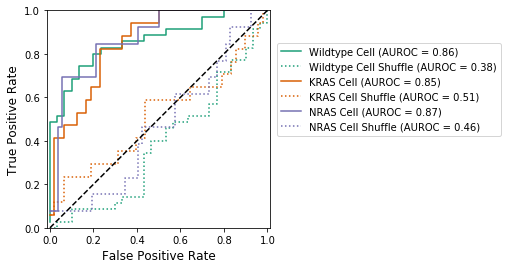

In [20]:
# Visualize ROC curves
plt.subplots(figsize=(4, 4))

labels = ['Wildtype Cell', 'KRAS Cell', 'NRAS Cell']
colors = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(n_classes):
    plt.plot(fpr_cell[i], tpr_cell[i],
             label='{} (AUROC = {})'.format(labels[i], round(auroc_cell[i], 2)),
             linestyle='solid',
             color=colors[i])
    
     # Shuffled Data
    plt.plot(fpr_shuff[i], tpr_shuff[i],
             label='{} Shuffle (AUROC = {})'.format(labels[i], round(auroc_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])

    
plt.axis('equal')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'cellline_roc_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

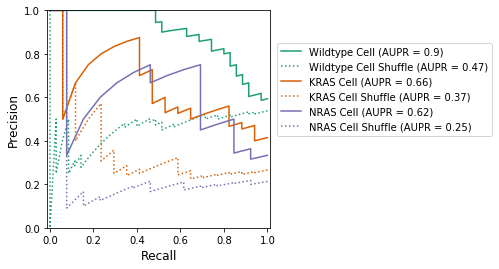

In [21]:
# Visualize PR curves
plt.subplots(figsize=(4, 4))

for i in range(n_classes):
    plt.plot(recall_cell[i], precision_cell[i],
             label='{} (AUPR = {})'.format(labels[i], round(aupr_cell[i], 2)),
             linestyle='solid',
             color=colors[i])
    
     # Shuffled Data
    plt.plot(recall_shuff[i], precision_shuff[i],
             label='{} Shuffle (AUPR = {})'.format(labels[i], round(aupr_shuff[i], 2)),
             linestyle='dotted',
             color=colors[i])
    
plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)

plt.tick_params(labelsize=10)

lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)

file = os.path.join('figures', 'cellline_pr_curve.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')

## Plot Classifier Score Distributions

This plot represents multiclass probability (`x axis`) scores (`y axis`) for all samples (`points`) and their corresponding ground truth status (`colors`).

In [22]:
class_dist_df = (
    mmcl_scores.reset_index()
    .merge(y_df, left_on='index', right_index=True)
    .melt(id_vars=['ras_status', 'index'], var_name='proba', value_name='class_proba')
    .sort_values(by='index')
    .reset_index(drop=True)
)
class_dist_df.head(6)

,ras_status,index,proba,class_proba
0,0,ALMC1_DJ_p27,wildtype,0.540429
1,0,ALMC1_DJ_p27,KRAS,0.205307
2,0,ALMC1_DJ_p27,NRAS,0.254263
3,0,ALMC2_DJ_p11,wildtype,0.740948
4,0,ALMC2_DJ_p11,KRAS,0.137716
5,0,ALMC2_DJ_p11,NRAS,0.121336


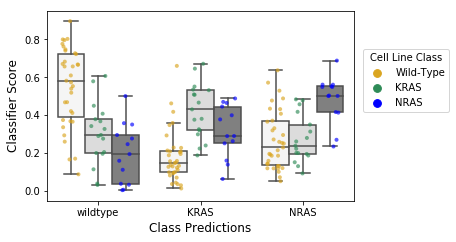

In [23]:
plt.subplots(figsize=(5.5, 3.5))
ax = sns.boxplot(x="proba",
                 y="class_proba",
                 data=class_dist_df,
                 hue='ras_status',
                 palette = {0: "whitesmoke", 1: 'gainsboro', 2: 'grey'},
                 fliersize=0)
ax = sns.stripplot(x="proba",
                   y="class_proba",
                   data=class_dist_df,
                   hue='ras_status', 
                   dodge=True,
                   edgecolor='black',
                   palette = {1: "seagreen", 0: 'goldenrod', 2: 'blue'},
                   jitter=0.25,
                   size=4,
                   alpha=0.65)

ax.set_ylabel('Classifier Score', fontsize=12)
ax.set_xlabel('Class Predictions', fontsize=12)

handles, labels = ax.get_legend_handles_labels()
lgd = plt.legend(handles[3:6], ['Wild-Type', 'KRAS', 'NRAS'],
               bbox_to_anchor=(1.03, 0.8),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=10)
lgd.set_title("Cell Line Class")

file = os.path.join('figures', 'cellline_predictions_boxscatter.pdf')
plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight')